- [Dog vs cat in Kaggle](https://www.kaggle.com/c/dogs-vs-cats)
- [Original note book](https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb)


## Basic Setup
Load library

In [2]:
%run env_setup.py
%matplotlib inline
from importlib import reload
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

Load data

In [3]:
from lessdeep.utils.datasets.kaggle import dog_cat

data_dir = dog_cat.download_data()

Default path

In [4]:
path = os.path.join(data_dir, 'sample')
#path = data_dir

## Use pretrained VGG model

- VGG19: large, slow, slightly accurate
- VGG16: small, fast

We use VGG16

In [5]:
## As large as you can, but no larger than 64 is recommanded
batch_size = 64

In [6]:
import vgg16
reload(vgg16)
from vgg16 import Vgg16

Using TensorFlow backend.


In [8]:
vgg = Vgg16()
batches = vgg.get_batches(os.path.join(path, 'train'), batch_size=batch_size)
val_batches = vgg.get_batches(os.path.join(path, 'valid'), batch_size=batch_size)

vgg.finetune(batches)
#vgg.fit(batches, val_batches, nb_epoch=1)

D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))


Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


## VGG16 details

In [6]:
vgg=Vgg16()

D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
D:\dev\learn\learning_notes\fast_ai\deeplearning1\vgg16.py:101: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))


- create vgg model based on keras
- weights are downloaded from web

In [7]:
batches = vgg.get_batches(os.path.join(path, 'train'), batch_size=4)

AttributeError: module 'vgg' has no attribute 'get_batches'

create a batch generator which load image from directory. Yes the is not necessarily contained by the model object. We can seperate the batch generator from vgg

In [71]:
imgs, labels = batches.next()
print(type(imgs), imgs.shape)
print(type(labels), labels.shape)

<class 'numpy.ndarray'> (20, 3, 224, 224)
<class 'numpy.ndarray'> (20, 2)


each batch load image by cpu and saved as numpy array

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


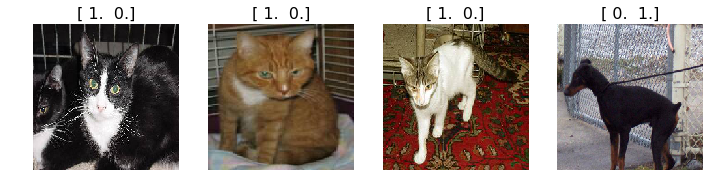

In [28]:
import utils.display as dis
reload(dis)
dis.imshow(imgs, titles=labels)

Data is loaded, model is prepared. Let's try predict

In [29]:
vgg.predict(imgs, details=True)

(array([ 0.2593,  0.1427,  0.0872,  0.5166], dtype=float32),
 array([232, 338, 355, 355], dtype=int64),
 ['Border_collie', 'guinea_pig', 'llama', 'llama'])

So it means

[dog maybe, a pig, llama not sure, llama I guess]

I don't really believe the pretrained model now.

In [31]:
vgg.classes[:4]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark']

## Build up VGG step by step

In [16]:
from numpy.random import random

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

Test environment

In [13]:
path = os.path.join(data_dir, 'sample')
#path = data_dir

### Get batchs

**What is batch?**

GPU is good at processing data in parallel. To make best use of GPU, multiple images is processed at a time, which is called a batch. After several batches, we take a simple test on validation dataset and these batches is called an epoch.

**Why ImageDataGenerator?**
- Image data is loaded from disk into memory as type of numpy array. But traning images are always too slow and too large for memory to load all at a time. A generator is used to load batch image only when required.
- Since the disk I/O is too slow compared with the memory, the ImageDataGenerator actually load images in a queue so that the next few batch is always in the memory.
- ImageDataGenerator not only load images, but also transform image randomly.So we get more data for traning and the model be trained will be more robust

In [63]:
# this is a general batch loading function
def get_batches(path_dir, generator, shuffle=True, batch_size=8, class_mode='categorial', **kwargs):
    '''Load batchs from directory and return a batch generator
    '''
    if type(generator) is keras.preprocessing.image.ImageDataGenerator:
        batches = generator.flow_from_directory(directory=path_dir, shuffle=shuffle,
                                                batch_size=32, **kwargs)
        if batches.samples < batch_size:
            batches.batch_size = batches.samples  # keras raise error when batch_size is larger than total samples
        return batches
    else:
        raise NotImplemented('Generator %s is not supported' % generator)

def vgg_get_batches(path_dir, generator=None, shuffle=True, batch_size=8,
                    class_mode='categorial', **kwargs):
    '''Setup preprocessing for vgg16
    '''
    if not generator:
        generator = ImageDataGenerator()

    #To make best use of cpu, preprocessing is added in batch loading
    def _norm_img(img):
        # input_shape=(3,224,224)  of (depth, height, width)
        # Mean of each channel as provided by VGG researchers
        vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
        return (img - vgg_mean)[::-1]  # convert rgb to bgr

    # make sure the data is loaded as (depth, height, width)
    generator.data_format = 'channels_first'

    # add normalization as preprocessing
    if generator.preprocessing_function:
        f = generator.preprocessing_function
        generator.preprocessing_function = lambda x, f_norm=_norm_img, f_old=f: f_norm(f_old(x))
    else:
        generator.preprocessing_function = _norm_img
    
    # NOTE: target_size must be (224, 224) for the pretrained model so that all image are resized
    return get_batches(path_dir, generator, shuffle=shuffle, batch_size=batch_size, class_mode=class_mode,
                       target_size=(224, 224), **kwargs)

def vgg_revert_images(imgs):
    vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
    if len(imgs.shape) == 3:
        return (imgs[::-1] + vgg_mean)  # convert bgr to rgb
    else:
        return (imgs[:, ::-1] + vgg_mean)  # convert bgr to rgb

train_bt = vgg_get_batches(os.path.join(path, 'train'), batch_size=batch_size)
val_bt = vgg_get_batches(os.path.join(path, 'valid'), batch_size=batch_size)

Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


**why another `vgg_get_batches`?**

- VGG is a model designed for image classification. Of course we can finetune to do more than calssification, but its input has to be images. So we force the input to be a ImageDataGenerator
- VGG require the input be normalized by substracting a mean and it's added into the generator as a preprocessor

**what is `vgg_revert_images`used for?**

since the batch is preprocessd, the images in batch is not good for visualization. The `vgg_revert_images` method is a convenient to convert the image back.

In [60]:
imgs, labels = train_bt.next()

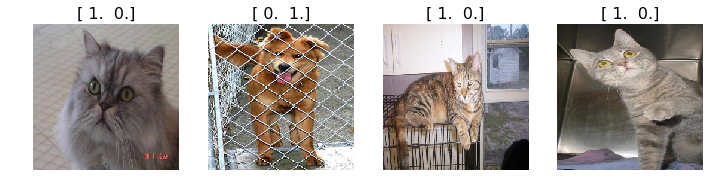

In [61]:
import lessdeep.utils.display as dis
dis.imshow(vgg_revert_images(imgs[:4,:]), titles=labels[:4])

### Create model

In [36]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from keras.utils.data_utils import get_file
from lessdeep.model import base

def vgg16_create(cache_dir=None):
    URL_BASE = 'http://files.fast.ai/models/'
    def _conv_block(model, layers, filters, input_shape=None):
        '''ZeroPad+Convolution+MaxPool
        
        :param layers: number of convolution layers
        :param filters: number of filters in each layer
        '''
        for _ in range(layers):
            kwargs = {}
            if input_shape:
                kwargs = {'input_shape': input_shape}
                input_shape = None
            model.add(ZeroPadding2D((1, 1), **kwargs)) # Zero pad with 1 pix
            model.add(Conv2D(filters, (3, 3), activation='relu')) # convolution layer with 3*3 kernel and stride (1,1) by default
        model.add(MaxPool2D((2, 2), strides=(2, 2)))
    
    def _dense_block(model):
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
    model = keras.models.Sequential()

    # Convolution layers
    _conv_block(model, 2, 64, input_shape=(3, 224,224))  # Keras need input_shape in first layer
    for layers, filters in [(2, 128), (3, 256), (3, 512), (3, 512)]:
        _conv_block(model, layers, filters)
    
    model.add(Flatten())
    # Dense layers
    _dense_block(model)
    _dense_block(model)
    model.add(Dense(1000, activation='softmax'))  # the trained ImageNet has 1000 classes as output
    
    # Download precompiled model weights
    if not cache_dir:
        cache_dir = base.cache_dir('vgg16')
    weights = get_file('vgg16.h5', URL_BASE+'vgg16.h5', cache_subdir=cache_dir,
                       hash_algorithm='md5', file_hash='884146ea83b6c8120d28f686b56eb471')
    model.load_weights(weights)
    return model
model = vgg16_create()

### Fintune

** what is fintune? **

- replace the final dense layer, and the new dense layer has proper output
- freeze the pretrained weights in the previous layers, so we only train the last layer

** why fintune? **

We suppose the required features are all extracted by the pretrained model. A simple dense layer is what we need.

In [43]:
from keras.optimizers import Adam
def vgg_fintune(model, classes):
    model.pop() # Remove the final layer
    for layer in model.layers:
        layer.trainable = False  # Freeze weights
    model.add(Dense(classes, activation='softmax'))

def vgg_compile(model, lr=0.001):
    # compile model with optimizer
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])

def vgg_fit(model, batch_gen, val_batch_gen, epochs):
    model.fit_generator(batch_gen,
                        steps_per_epoch=batch_gen.samples // batch_gen.batch_size,
                        epochs=epochs,
                        validation_data=val_batch_gen,
                        validation_steps=val_batch_gen.samples//val_batch_gen.batch_size)
vgg_fintune(model, classes=train_bt.classes)
vgg_compile(model)

In [64]:
vgg_fit(model, train_bt, val_bt, epochs=1)

Epoch 1/1
1/1 [==============================] - 61s - loss: 1.9801 - acc: 0.3500 - val_loss: 1.3161 - val_acc: 0.5000


### Prediction

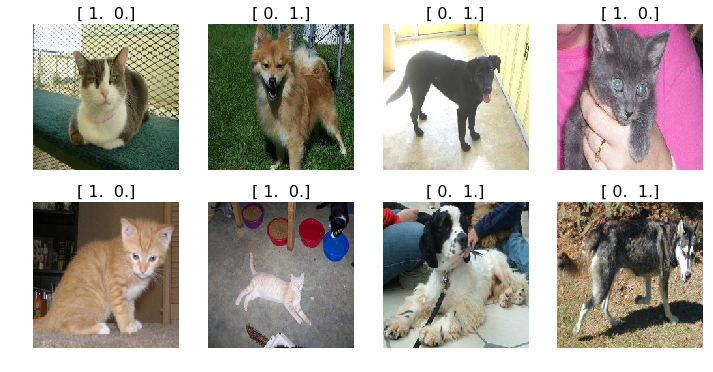

(array([ 0.7802,  0.9478,  0.8451,  0.9283,  0.7289,  0.8905,  0.9111,  0.6431], dtype=float32), array([0, 0, 0, 0, 0, 1, 0, 1], dtype=int64), ['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog'])


In [70]:
def vgg_predict(model, imgs, class_labels=None):
    # predict for numpy array
    preds = model.predict(imgs)
    
    # get the most possible class
    idxes = np.argmax(preds, axis=1)
    
    # get the probabilities
    preds = [preds[i, max_i] for i, max_i in enumerate(idxes)]
    
    # get class label
    if class_labels is None:
        class_labels = range(model.output_shape[-1])
    assert(len(class_labels) == model.output_shape[-1])
    classes = [class_labels[i] for i in idxes]
    
    return np.array(preds), idxes, classes

imgs, labels = val_bt.next()
dis.imshow(vgg_revert_images(imgs), rows=2, titles=labels)
print(vgg_predict(model, imgs, ['cat', 'dog']))